In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
%matplotlib inline
import torch
from deepseries.models import BasicSeq2Seq
from deepseries.dataset import Property, TimeSeries, Seq2SeqDataLoader
from deepseries.nn.loss import MSELoss, RMSELoss
from deepseries.train import Learner
from deepseries.optim import ReduceCosineAnnealingLR
import deepseries.functional as F
from deepseries.analysis import SeriesAnalysisModel
from torch.optim import Adam
from torch import nn
import matplotlib as mpl
from sklearn.metrics import mean_absolute_error
import chinese_calendar as calendar
import datetime as dt
info = pd.read_excel("../data/info.xlsx")
recored = info.set_index("contributor_id")['huangzf']
info = pd.read_excel("../data/info.xlsx").set_index("contributor_id")[['pjt_name', 'pjt_type']]
norm_score = pd.read_csv(r"../data/20200315_20200415.csv")

In [3]:
# util function

def normalize(x, axis, fill_zero=True):
    mu = np.nanmean(x, axis, keepdims=True)
    std = np.nanstd(x, axis, keepdims=True)
    x_norm = (x - mu) / std
    if fill_zero:
        x_norm = np.nan_to_num(x_norm)
    return x_norm, mu, std

In [4]:
power = pd.read_csv('../data/df.csv', parse_dates=['data_time'])[['data_time', 'cid', 'value']]
power = power.set_index("data_time").groupby("cid").resample("1H").sum().reset_index()
power = power.pivot(index='cid', columns='data_time', values='value')
power = power.apply(np.log1p)

In [5]:
analysis = SeriesAnalysisModel(power.values)

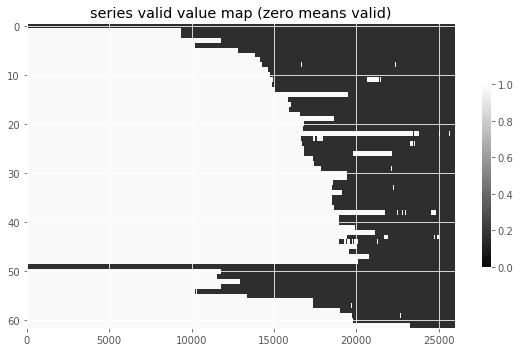

In [6]:
analysis.plot_valid()

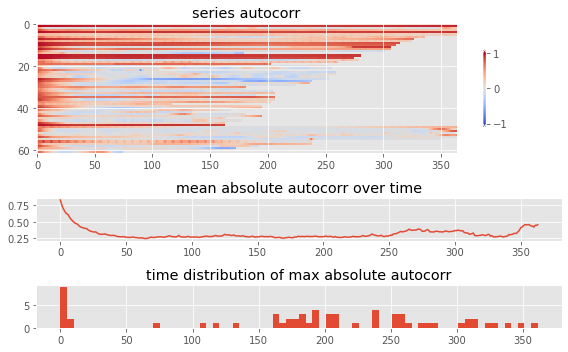

In [7]:
analysis.get_autocorr(np.arange(24*1, 24*365, 24)).plot_autocorr()

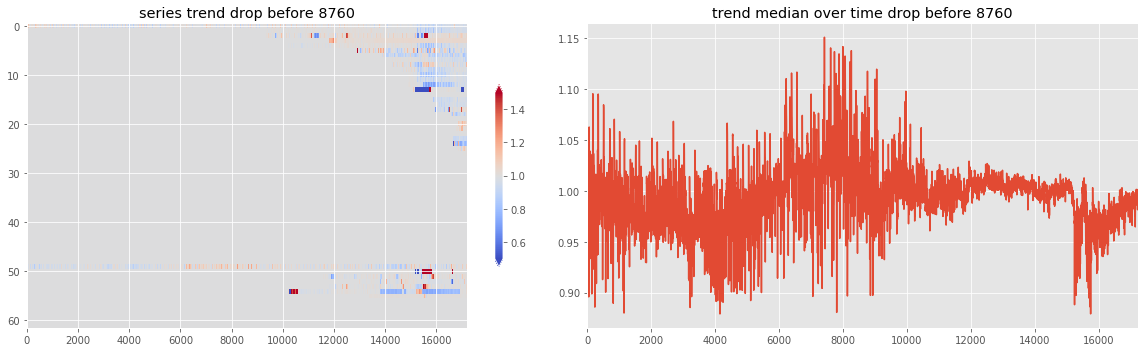

In [8]:
analysis.get_trend(max_T=365*24).plot_trend()

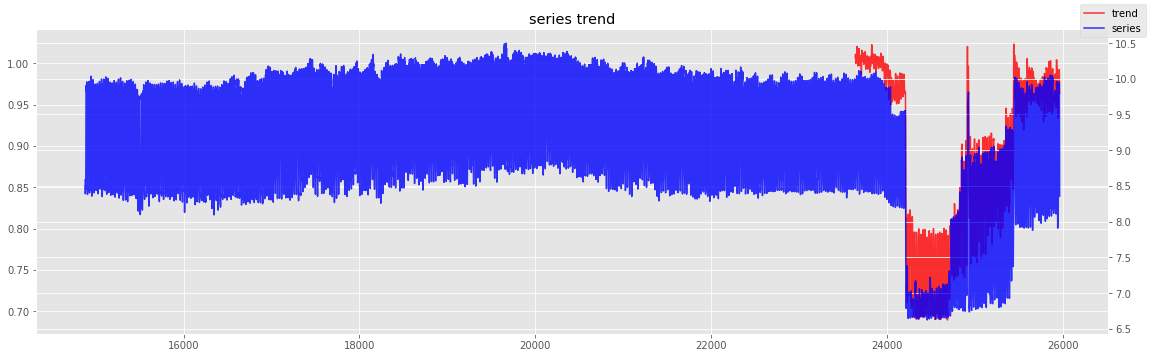

In [9]:
analysis.plot_trend(12)

In [10]:
N_TEST = 24 * 30
N_VALID = 24 * 2
DROP_ZERO = True
DEC_LEN = 24 * 2
ENC_LEN = 24 * 7
time_free_space = 24

drop_before = 15000

In [11]:
xy = power.values

xy_valid = np.bitwise_and(~np.isnan(xy), xy!=0)
starts, ends = F.get_valid_start_end(xy, ~xy_valid)


xy, xy_mean, xy_std = normalize(xy, axis=1)
power = (power - xy_mean) / xy_std

In [12]:
xy_auto_corr = F.batch_autocorr(xy, [7*24, 14*24, 180*24, 365*24], starts, ends, 1.05)
xy_auto_corr, _, _ = normalize(xy_auto_corr, 0)

In [13]:
xy_lags, _, _ = normalize(F.make_lags(xy, [7*24, 14*24, 180*24, 365*24]), axis=2)
xy_valid = np.expand_dims(xy_valid.astype("float32"), 1)
xy_lag_valid = np.concatenate([xy_lags,  xy_valid], axis=1).astype("float32")

In [14]:
weights = (xy_valid.astype("float32") + 1e-6 ).squeeze()
weights = weights * xy_mean / xy_mean.mean()
weights[:, np.where((power.columns >= "2020-02-01") & (power.columns < "2020-03-01"), 1, 0)] = \
weights[:, np.where((power.columns >= "2020-02-01") & (power.columns < "2020-03-01"), 1, 0)] * 0.1
weights = np.expand_dims(weights, 1)

In [15]:
xy_cat = np.expand_dims(np.arange(len(weights)), 1)

In [16]:
def get_holiday_features(dts):
    select_holidays = ["Spring Festival", "National Day", "Labour Day", "New Year's Day", "Mid-autumn Festival", "Tomb-sweeping Day"]
    def _get_holidays(x):
        is_holiday, holiday_name = calendar.get_holiday_detail(x)
        if holiday_name in select_holidays and is_holiday:
            return holiday_name
    holidays = pd.get_dummies(pd.Series(dts).apply(lambda x: _get_holidays(x)))
    holidays['sick'] = np.where((power.columns >= "2020-02-01") & (power.columns < "2020-03-01"), 1, 0)
    holidays.index= dts
    return holidays

def holiday_apply(x, holidays, func):
    result = pd.DataFrame()
    for h in holidays.columns:
        result[h] = x.loc[:, holidays[h].values.astype(bool)].agg(func, axis=1).values
    return result

holidays = get_holiday_features(power.columns)
xy_holiday_mean = holiday_apply(power, holidays, np.mean).values

xy_holiday_mean = normalize(xy_holiday_mean, 0)[0]

In [17]:
def periodic_feature(x, T):
    psin = np.sin(x * np.pi * 2 / T)
    pcos = np.cos(x * np.pi * 2 / T)
    return np.stack([psin, pcos], axis=0)


xy_weekday = pd.get_dummies(power.columns.weekday).T.values
xy_hour = pd.get_dummies(power.columns.hour).T.values
xy_month = pd.get_dummies(power.columns.month).T.values
xy_date = np.concatenate([xy_weekday, xy_hour, xy_month, holidays.T], 0)
xy_date = np.repeat(np.expand_dims(xy_date, 0), xy.shape[0], axis=0)

In [18]:
xy = np.expand_dims(xy, 1).transpose(0, 2, 1)[:, drop_before:]
xy_property_num = np.concatenate([xy_holiday_mean, xy_auto_corr], axis=1) # 62 x 11
xy_series_num = np.concatenate([xy_lag_valid, xy_date], 1).transpose(0, 2, 1)[:, drop_before:]
weights = weights.transpose(0, 2, 1)[:, drop_before:]

In [19]:
class ForwardSpliter:
    
    def split(self, time_idx, enc_len, dec_len, valid_size):
        if valid_size < 1:
            valid_size = int(np.floor(len(time_idx) * valid_size))
        valid_idx = time_idx[-(valid_size+enc_len):]
        train_idx = time_idx[:-valid_size]
        return train_idx, valid_idx
    
spliter = ForwardSpliter()
train_idx, valid_idx = spliter.split(np.arange(xy.shape[1]), ENC_LEN, DEC_LEN, N_TEST+N_VALID)
valid_idx, test_idx = spliter.split(valid_idx, ENC_LEN, DEC_LEN, N_TEST)

train_xy = TimeSeries(xy[:,train_idx])
valid_xy = TimeSeries(xy[:,valid_idx])

train_xy_features = TimeSeries(xy_series_num[:, train_idx])
valid_xy_features = TimeSeries(xy_series_num[:, valid_idx])

train_xy_property_num = Property(xy_property_num)
valid_xy_property_num = Property(xy_property_num)

train_weight = TimeSeries(weights[:, train_idx])
valid_weight = TimeSeries(weights[:, valid_idx])

train_xy_cat = Property(xy_cat)
valid_xy_cat = Property(xy_cat)

train_frame = Seq2SeqDataLoader(train_xy, batch_size=8, enc_lens=ENC_LEN, dec_lens=DEC_LEN, use_cuda=True, mode='train', time_free_space=24,
                          enc_num_feats=[train_xy_features, train_xy_property_num],
                                enc_cat_feats=[train_xy_cat],
                                dec_num_feats=[train_xy_features, valid_xy_property_num], 
                                dec_cat_feats=[valid_xy_cat],
                                weights=train_weight, seq_last=False)
valid_frame = Seq2SeqDataLoader(valid_xy, batch_size=64, enc_lens=ENC_LEN, dec_lens=DEC_LEN, use_cuda=True, mode='train', time_free_space=0,
                         time_interval=48, 
                                enc_num_feats=[train_xy_features, train_xy_property_num], 
                                enc_cat_feats=[train_xy_cat],
                                dec_num_feats=[train_xy_features, valid_xy_property_num], 
                                dec_cat_feats=[valid_xy_cat],
                                seq_last=False)

test_xy = xy[:, test_idx]
test_xy_num_feats = np.concatenate([xy_series_num[:, test_idx], np.repeat(np.expand_dims(xy_property_num, 1), len(test_idx), 1)], axis=2)

In [80]:
# model = BasicSeq2Seq(1, 512, enc_num=66, dec_num=66, enc_cat=[(62, 2)], dec_cat=[(62,2)], n_layers=1, dropout=0.2)
# opt = Adam(model.parameters(), 0.002)
# loss_fn = RMSELoss()
# model.cuda()
# lr_scheduler = ReduceCosineAnnealingLR(opt, 64, eta_min=5e-5)
# learner = Learner(model, opt, loss_fn, './power_env_rnn', verbose=5000, lr_scheduler=lr_scheduler)
learner.fit(500, train_frame, valid_frame, patient=64, start_save=1, early_stopping=False)

[[04/30/2020 14:55:02]] start training >>>>>>>>>>>  see log: tensorboard --logdir ./power_env_rnn\logs
[[04/30/2020 14:55:05]] epoch 859 / 1358, batch 100%, train loss 0.3512, valid loss 0.5954, cost 0.0 min
[[04/30/2020 14:55:08]] epoch 860 / 1358, batch 100%, train loss 0.3400, valid loss 0.6044, cost 0.0 min
[[04/30/2020 14:55:11]] epoch 861 / 1358, batch 100%, train loss 0.3864, valid loss 0.5898, cost 0.1 min
[[04/30/2020 14:55:14]] epoch 862 / 1358, batch 100%, train loss 0.2245, valid loss 0.5794, cost 0.0 min
[[04/30/2020 14:55:16]] epoch 863 / 1358, batch 100%, train loss 0.3472, valid loss 0.5791, cost 0.0 min
[[04/30/2020 14:55:19]] epoch 864 / 1358, batch 100%, train loss 0.2419, valid loss 0.5899, cost 0.0 min
[[04/30/2020 14:55:22]] epoch 865 / 1358, batch 100%, train loss 0.4929, valid loss 0.5864, cost 0.0 min
[[04/30/2020 14:55:25]] epoch 866 / 1358, batch 100%, train loss 0.4072, valid loss 0.5822, cost 0.0 min
[[04/30/2020 14:55:28]] epoch 867 / 1358, batch 100%, tra

[[04/30/2020 14:58:46]] epoch 936 / 1358, batch 100%, train loss 0.2496, valid loss 0.6074, cost 0.0 min
[[04/30/2020 14:58:48]] epoch 937 / 1358, batch 100%, train loss 0.2380, valid loss 0.6065, cost 0.0 min
[[04/30/2020 14:58:51]] epoch 938 / 1358, batch 100%, train loss 0.3730, valid loss 0.5988, cost 0.0 min
[[04/30/2020 14:58:55]] epoch 939 / 1358, batch 100%, train loss 0.6499, valid loss 0.5950, cost 0.1 min
[[04/30/2020 14:58:57]] epoch 940 / 1358, batch 100%, train loss 0.3514, valid loss 0.5896, cost 0.0 min
[[04/30/2020 14:59:00]] epoch 941 / 1358, batch 100%, train loss 0.3131, valid loss 0.5865, cost 0.0 min
[[04/30/2020 14:59:03]] epoch 942 / 1358, batch 100%, train loss 0.3490, valid loss 0.5788, cost 0.0 min
[[04/30/2020 14:59:06]] epoch 943 / 1358, batch 100%, train loss 0.2941, valid loss 0.5729, cost 0.0 min
[[04/30/2020 14:59:08]] epoch 944 / 1358, batch 100%, train loss 0.3545, valid loss 0.5743, cost 0.0 min
[[04/30/2020 14:59:11]] epoch 945 / 1358, batch 100%, t

[[04/30/2020 15:02:23]] epoch 1013 / 1358, batch 100%, train loss 0.2136, valid loss 0.5831, cost 0.0 min
[[04/30/2020 15:02:26]] epoch 1014 / 1358, batch 100%, train loss 0.2224, valid loss 0.5885, cost 0.0 min
[[04/30/2020 15:02:29]] epoch 1015 / 1358, batch 100%, train loss 0.2167, valid loss 0.5985, cost 0.1 min
[[04/30/2020 15:02:32]] epoch 1016 / 1358, batch 100%, train loss 0.2395, valid loss 0.6061, cost 0.0 min
[[04/30/2020 15:02:35]] epoch 1017 / 1358, batch 100%, train loss 0.3940, valid loss 0.6109, cost 0.0 min
[[04/30/2020 15:02:37]] epoch 1018 / 1358, batch 100%, train loss 0.4150, valid loss 0.5846, cost 0.0 min
[[04/30/2020 15:02:40]] epoch 1019 / 1358, batch 100%, train loss 0.3897, valid loss 0.5729, cost 0.0 min
[[04/30/2020 15:02:43]] epoch 1020 / 1358, batch 100%, train loss 0.3237, valid loss 0.5689, cost 0.0 min
[[04/30/2020 15:02:45]] epoch 1021 / 1358, batch 100%, train loss 0.3944, valid loss 0.5726, cost 0.0 min
[[04/30/2020 15:02:48]] epoch 1022 / 1358, bat

RuntimeError: write(): fd 6 failed with No space left on device

In [65]:
learner.load(1000)

In [66]:
preds = []
trues = []
for batch in valid_frame:
    preds.append(learner.model.predict(**batch[0]))
    trues.append(batch[1])

In [67]:
trues = np.expm1(torch.cat(trues, 2).squeeze().cpu().numpy() * xy_std + xy_mean)

In [68]:
preds = np.expm1(torch.cat(preds, 2).squeeze().cpu().numpy() * xy_std + xy_mean)

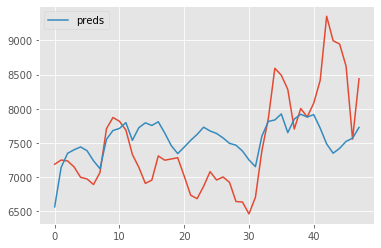

In [69]:
k = 20

plt.plot(trues[k])
plt.plot(preds[k], label='preds')
plt.legend()

In [77]:
test_xy = torch.as_tensor(xy[:, test_idx]).float().cuda()
test_xy_num_feats = torch.as_tensor(
    np.concatenate([xy_series_num[:, test_idx], np.repeat(np.expand_dims(xy_property_num, 1), len(test_idx), 1)], axis=2)).float().cuda()
test_xy_num_feats = torch.as_tensor(test_xy_num_feats).float().cuda()
test_xy_cat_feats = torch.as_tensor(np.repeat(np.expand_dims(xy_cat, 1), test_xy.shape[1], 1)).long().cuda()

def plot(x_true, y_true, y_pred):
    enc_ticks = np.arange(x_true.shape[1])
    dec_ticks = np.arange(y_pred.shape[1]) + x_true.shape[1]
    for idx, name in enumerate(power.index):
        plt.figure(figsize=(12, 3))
        plt.plot(enc_ticks, x_true[idx])
        plt.plot(dec_ticks, y_pred[idx], label='pred')
        plt.plot(dec_ticks, y_true[idx], label='true')
        plt.title(idx)
        plt.legend()

def wmape(y_hat, y):
    scores = []
    for day in range(int(y.shape[0] / 24)):
        scores.append(np.abs(y[day*24: (day+1)*24] - y_hat[day*24: (day+1)*24]).sum() / np.sum(y[day*24: (day+1)*24]))
    return scores

def metric(y_true, y_pred):
    scores = {}
    for idx, name in enumerate(power.index):
        scores[name] = wmape(y_pred[idx], y_true[idx])
    return pd.DataFrame(scores)


def predict(learner, xy, x_num, x_cat, y_num, y_cat, epoch):
    learner.load(epoch)
    learner.model.eval()
    learner.model.cuda()
    preds = []
    days = int(xy.shape[1] / 24 - ENC_LEN / 24 - DEC_LEN/24 + 1)
    for day in range(days):
        step = day * 24
        step_pred = model(
            xy[:,step: step+ENC_LEN], 
            enc_num=x_num[:, step: step+ENC_LEN],
            dec_num=y_num[:, step+ENC_LEN: step+ENC_LEN+DEC_LEN], 
            enc_cat=x_cat[:, step: step+ENC_LEN],
            dec_cat=y_cat[:, step+ENC_LEN: step+ENC_LEN+DEC_LEN], 
            dec_len=DEC_LEN
        ).cpu().detach().numpy()
        preds.append(step_pred[:, -24:])
    
    preds = np.concatenate(preds, axis=1)
    preds = np.expm1(preds.squeeze() * xy_std + xy_mean)
    
    x_true = np.expm1(xy[:,:ENC_LEN + 24].cpu().numpy().squeeze() * xy_std + xy_mean)
    y_true = np.expm1(xy[:,ENC_LEN + 24:].cpu().numpy().squeeze() * xy_std + xy_mean)
    
    return x_true, y_true, preds

In [71]:
norm_data = pd.read_csv("../data/20200315_20200415.csv").drop(['Unnamed: 0', 'model_name'], axis=1)
norm_data = norm_data[norm_data.contributor_id.isin(power.index)].reset_index(drop=True)
norm_data = norm_data.set_index("contributor_id").loc[power.index].reset_index()
norm_data['data_time'] = pd.to_datetime(norm_data.data_time)
norm_data = norm_data.set_index("data_time").groupby("contributor_id").resample('1H')[['forecast_pwr', 'value']].sum().reset_index()
norm_true = norm_data.pivot(index='contributor_id', columns='data_time', values='value').iloc[:, 48:]
norm_pred = norm_data.pivot(index='contributor_id', columns='data_time', values='forecast_pwr').iloc[:, 48:]


x_true, y_true, y_pred  = predict(learner, test_xy, test_xy_num_feats, test_xy_cat_feats, test_xy_num_feats, test_xy_cat_feats, 358)
scores = pd.DataFrame([metric(y_true, y_pred).mean().rename("wave"), 
                       metric(norm_true.values, norm_pred.values).mean().rename("v1")]).T.dropna()

In [72]:
scores.describe()

wave         v1
count  6.200000e+01  62.000000
mean   3.378510e+08   0.526637
std    2.660241e+09   1.994470
min    2.523628e-02   0.017290
25%    1.376610e-01   0.089047
50%    2.078312e-01   0.171180
75%    4.124732e-01   0.306400
max    2.094676e+10  15.607201

In [73]:
scores[scores.wave>1]

wave         v1
91E0B6DC00D01783E0530BC8100A0E30  4.386554e+00  15.607201
91E0B6DC00E91783E0530BC8100A0E30  2.094676e+10   0.150747
91E0C8BAA12E259EE0530BC8100AFFB2  1.676668e+00   3.111139
91E0C8BAA1B4259EE0530BC8100AFFB2  1.204936e+00   1.114753

In [74]:
np.where(scores.index == "91E0B6DC00E91783E0530BC8100A0E30")

(array([22], dtype=int64),)

In [75]:
scores.sort_values("wave")

wave         v1
91E0C8BAA1B7259EE0530BC8100AFFB2  2.523628e-02   0.018249
91E0B6DC00FF1783E0530BC8100A0E30  3.120944e-02   0.018072
91E0B6DC00D81783E0530BC8100A0E30  5.018942e-02   0.018146
91E0C8BAA1CB259EE0530BC8100AFFB2  6.856961e-02   0.052491
91E0B6DC00BA1783E0530BC8100A0E30  8.864734e-02   0.033071
...                                        ...        ...
91E0B6DC01411783E0530BC8100A0E30  7.025992e-01   0.876168
91E0C8BAA1B4259EE0530BC8100AFFB2  1.204936e+00   1.114753
91E0C8BAA12E259EE0530BC8100AFFB2  1.676668e+00   3.111139
91E0B6DC00D01783E0530BC8100A0E30  4.386554e+00  15.607201
91E0B6DC00E91783E0530BC8100A0E30  2.094676e+10   0.150747

[62 rows x 2 columns]

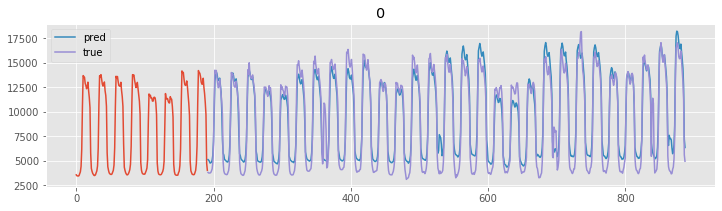

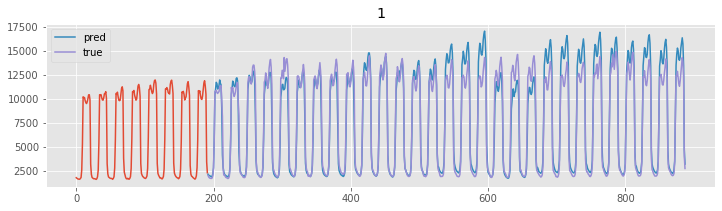

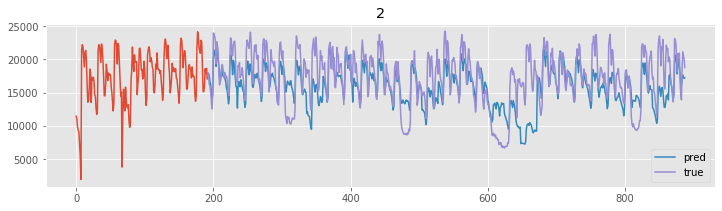

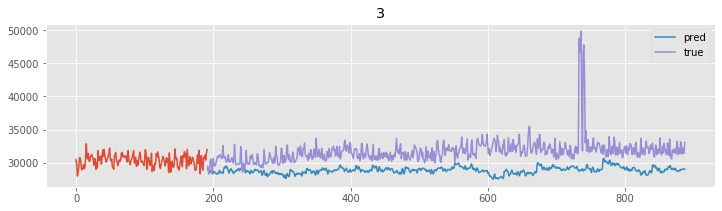

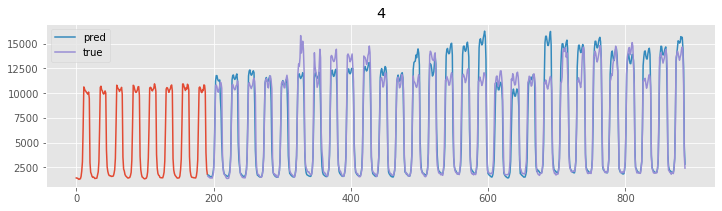

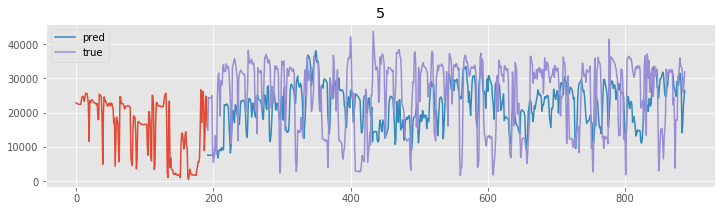

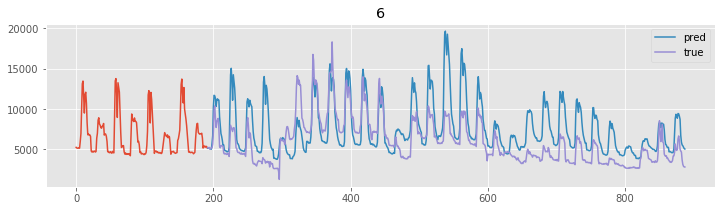

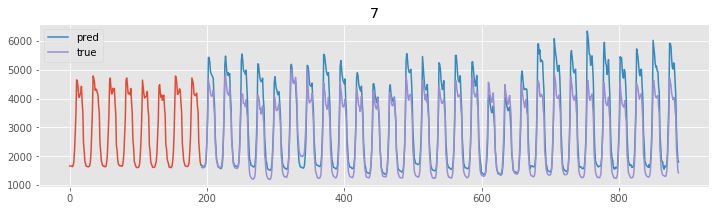

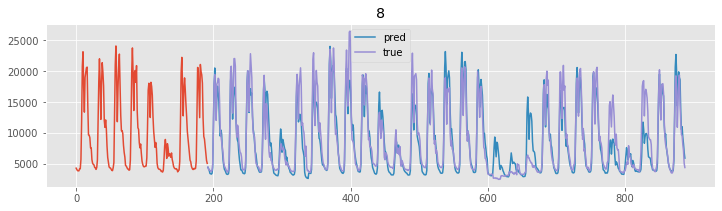

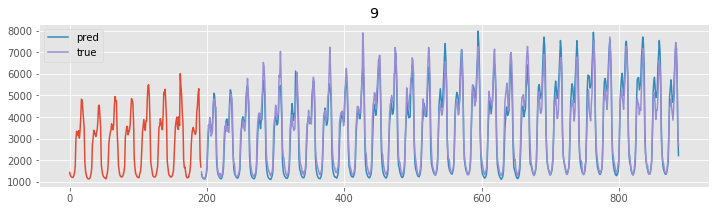

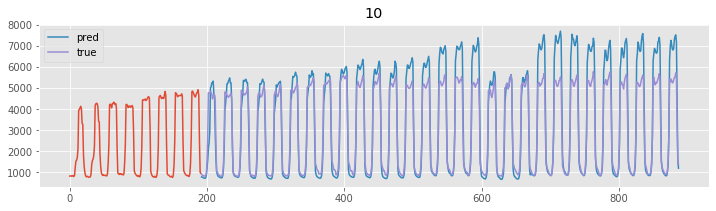

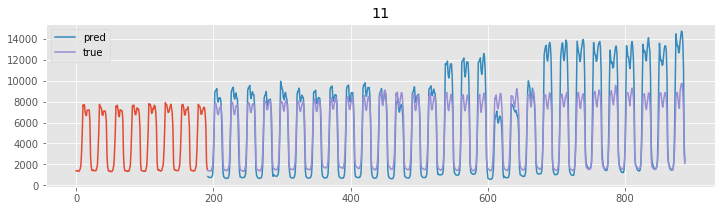

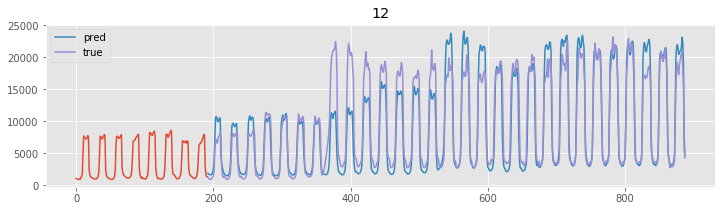

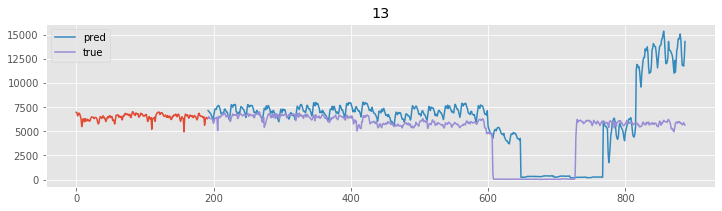

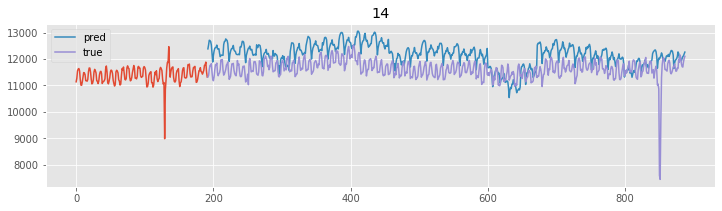

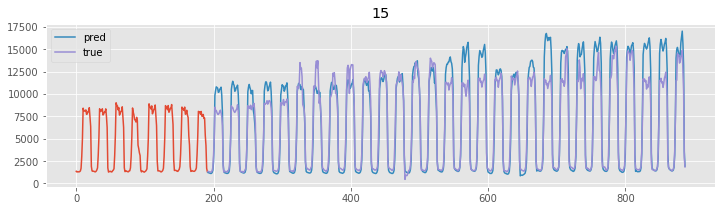

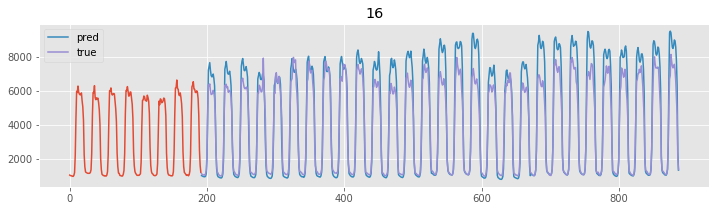

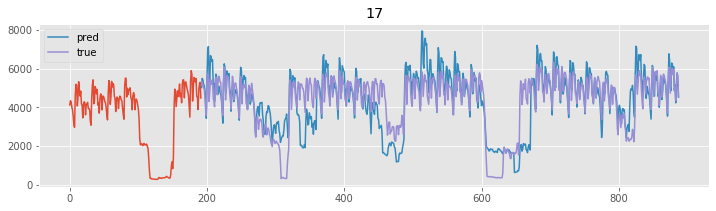

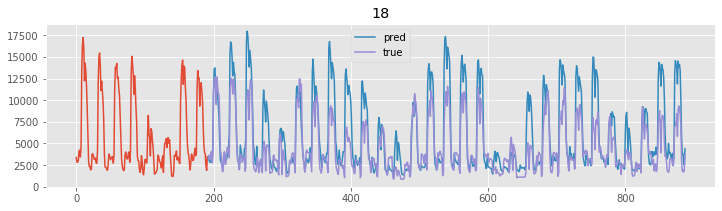

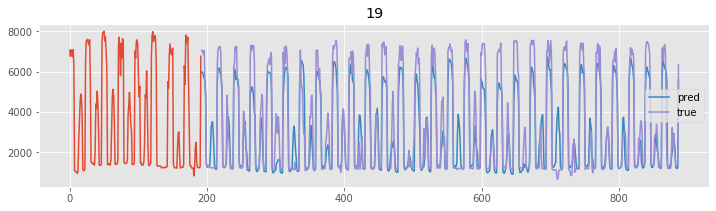

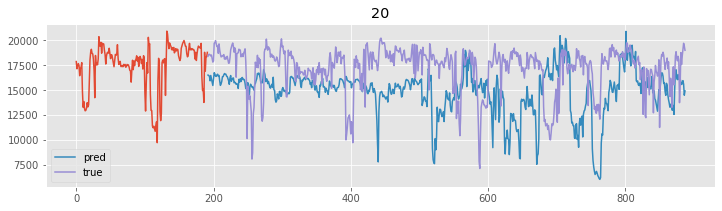

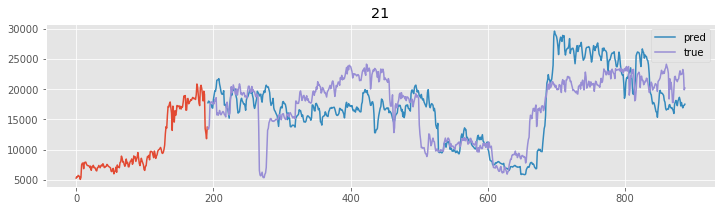

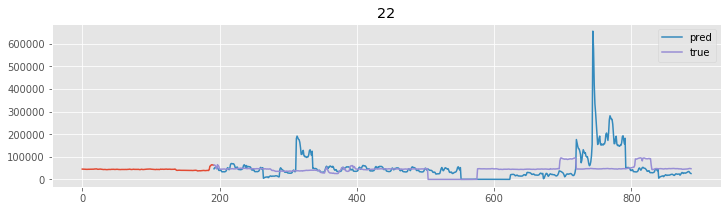

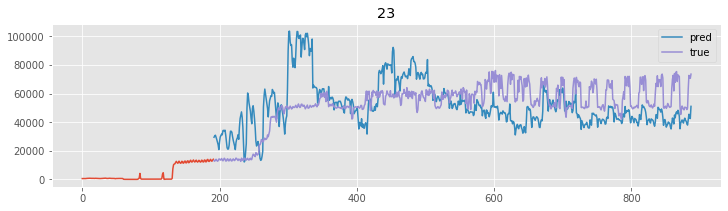

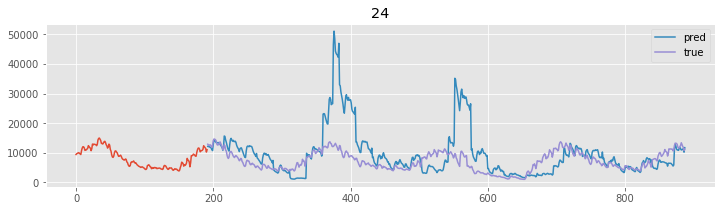

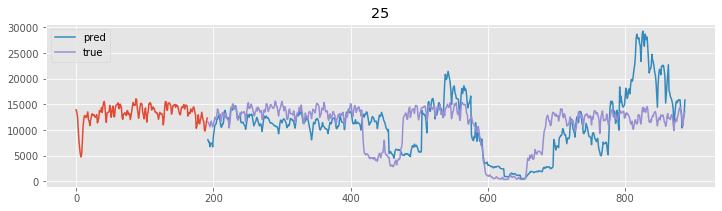

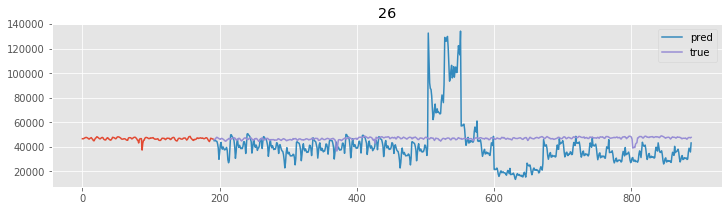

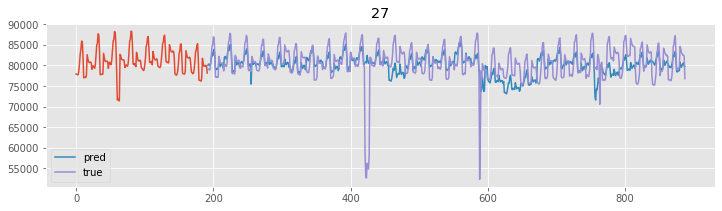

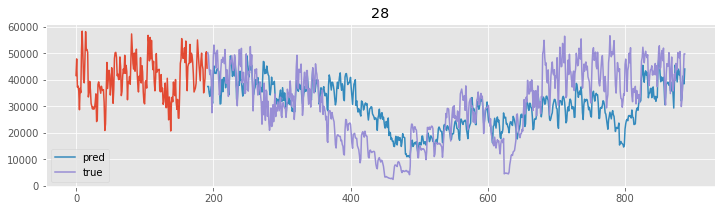

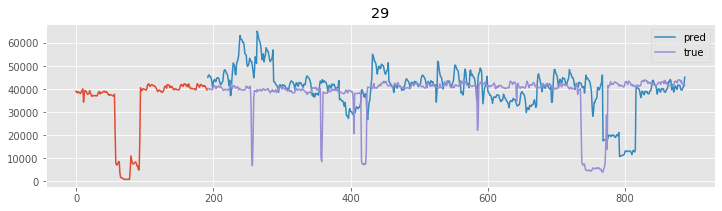

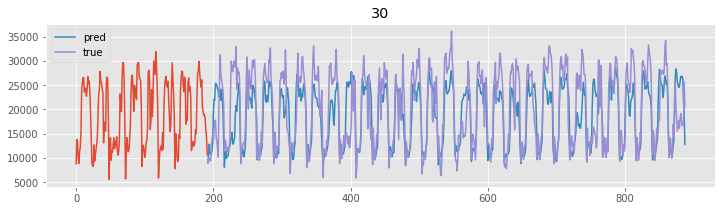

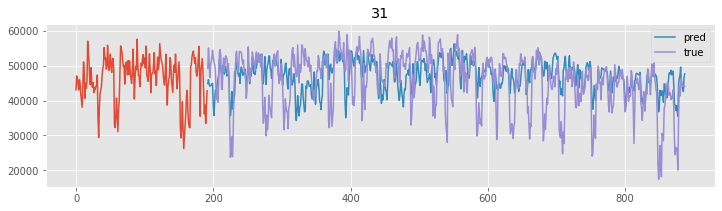

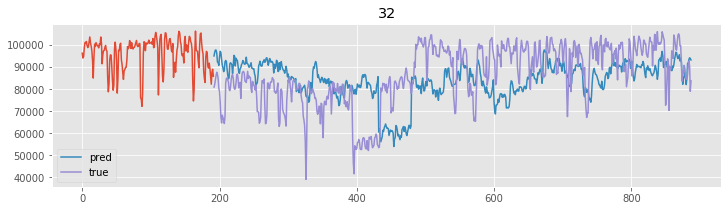

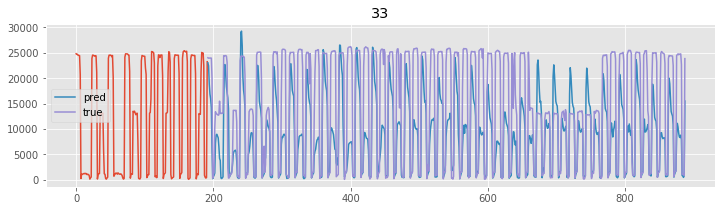

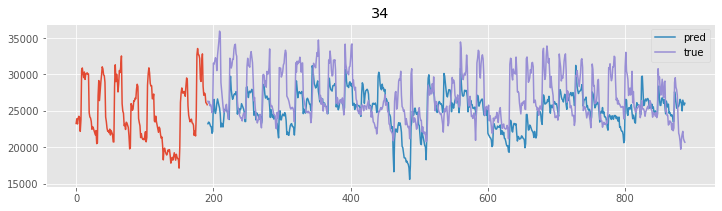

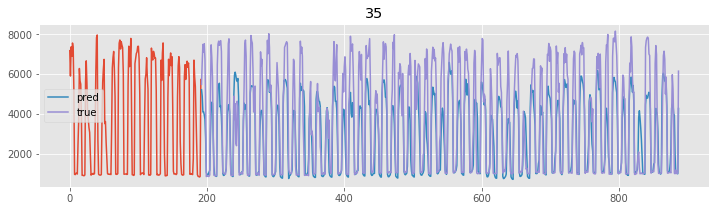

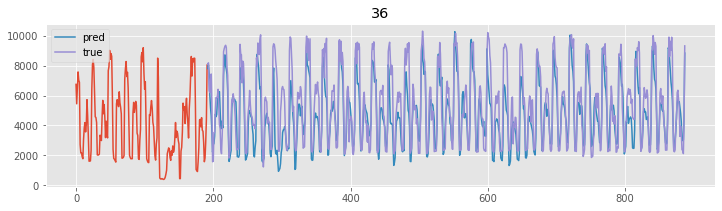

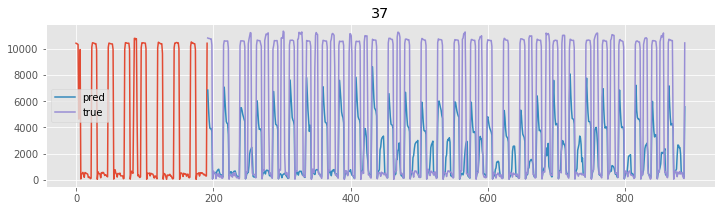

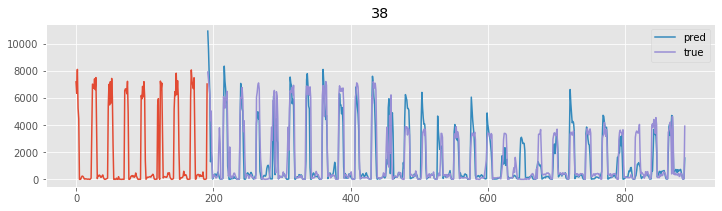

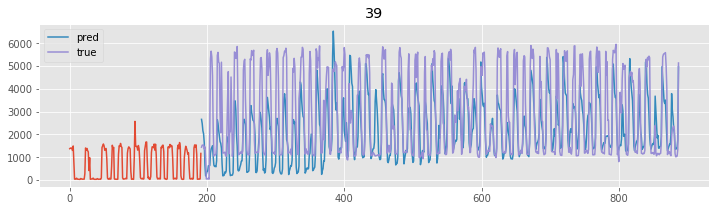

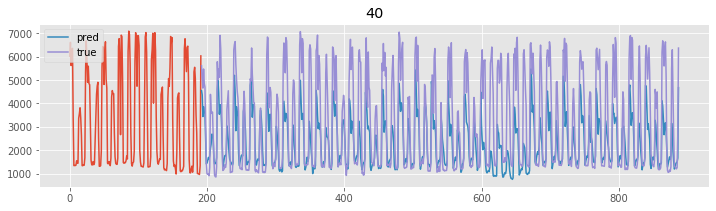

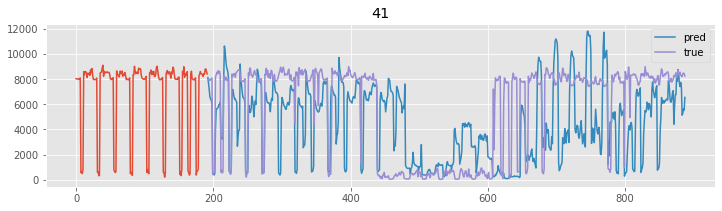

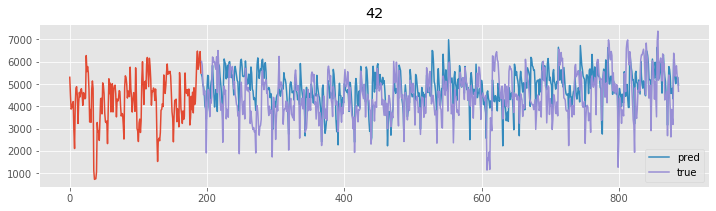

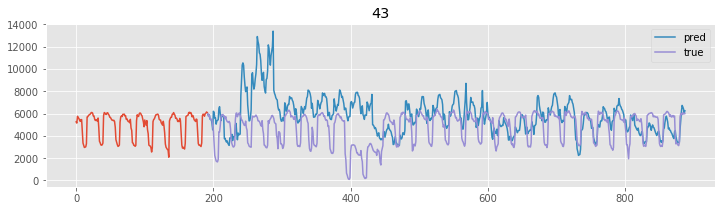

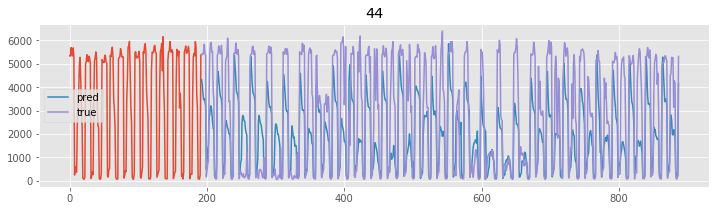

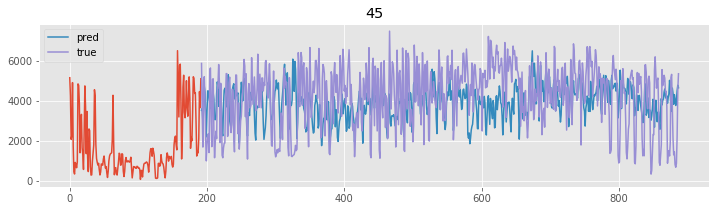

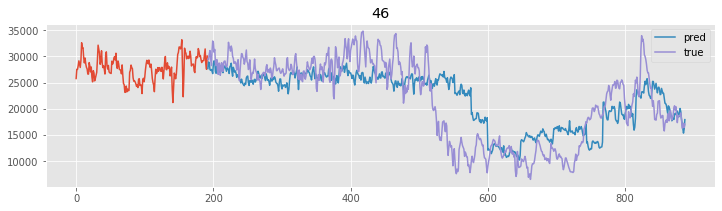

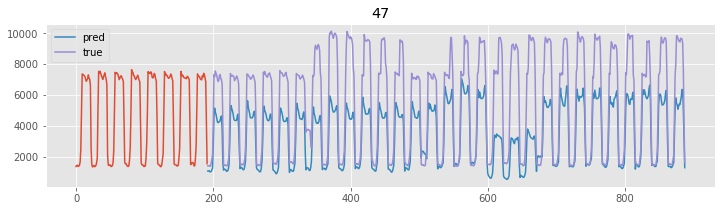

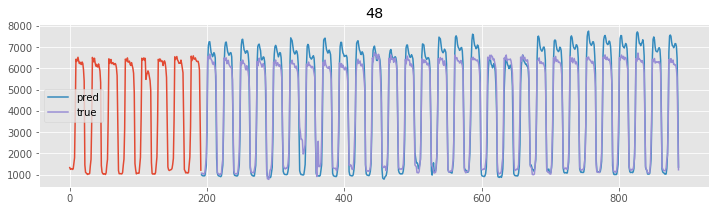

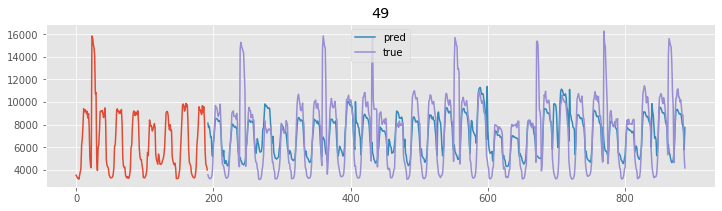

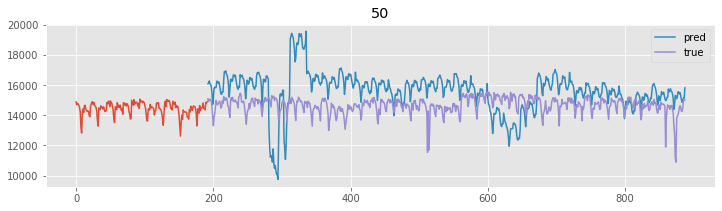

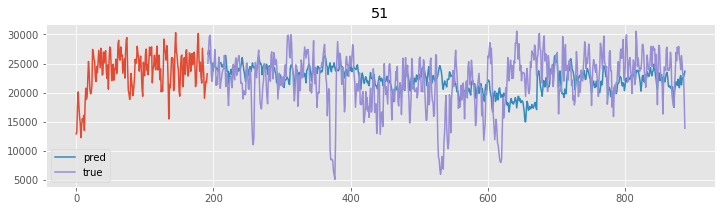

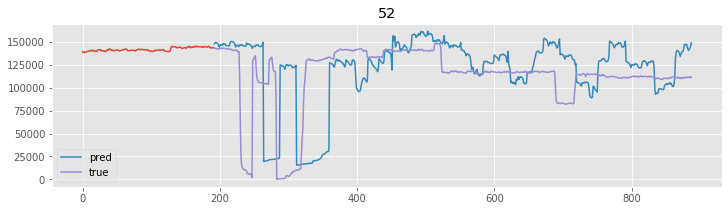

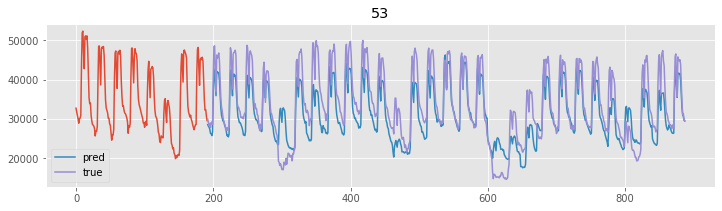

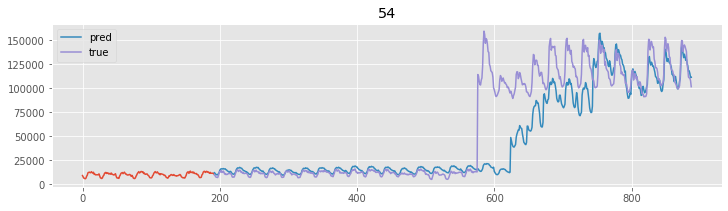

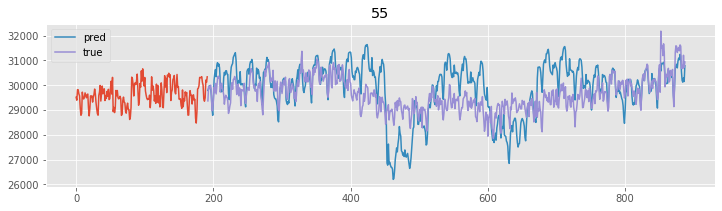

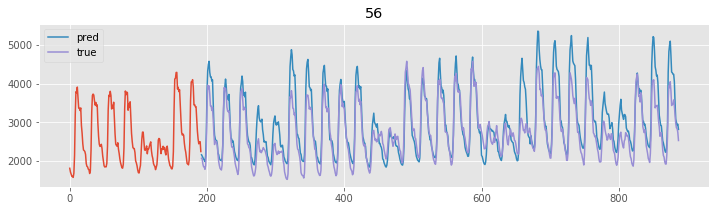

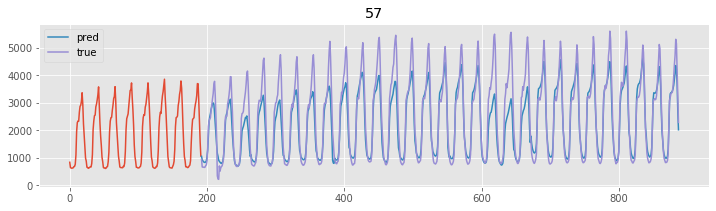

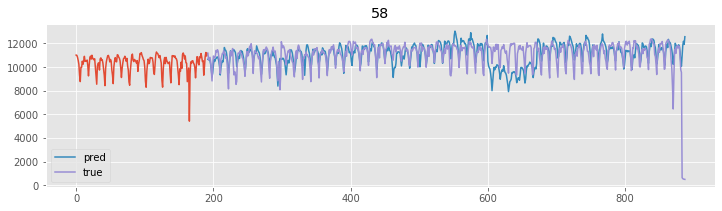

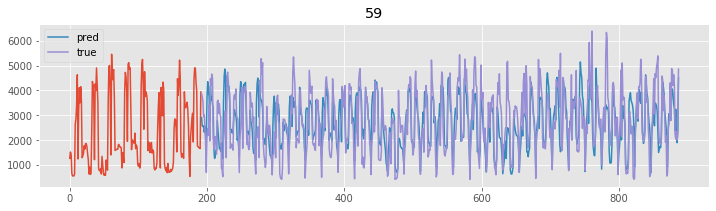

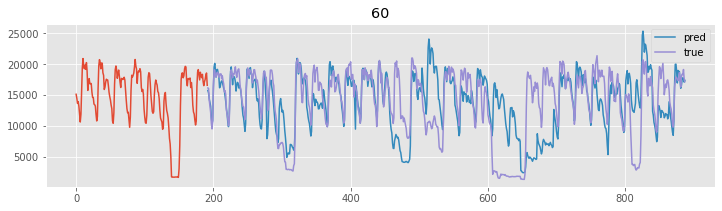

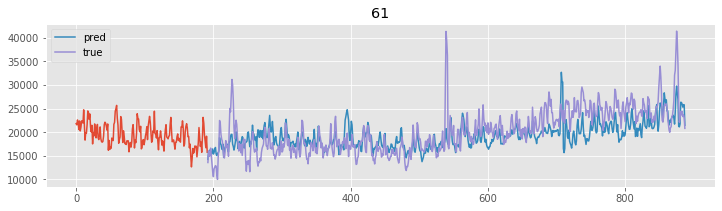

In [78]:
plot(x_true, y_true, y_pred)

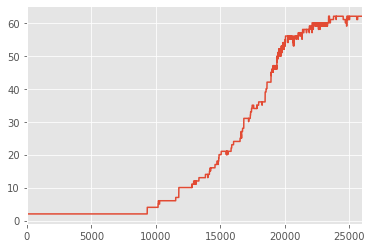

In [83]:
pd.DataFrame(xy_lag_valid[:, -1]).sum().plot()

In [64]:
(scores.wave < scores.v1).sum()

18